## Import the required packages

In [20]:
import pandas as pd
import yfinance as yf
import datetime

import pmdarima as pm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Select asset and time period

In [21]:
start_training = datetime.date(2010, 1, 1)
end_training = datetime.date(2020, 12, 31)
start_testing = datetime.date(2021, 1, 1)
end_testing = datetime.datetime.today()
ticker = "RELIANCE.NS"

## Download training data

In [22]:
df_training = yf.download(ticker, start=start_training, end=end_training, progress=False)
print(f"Downloaded {df_training.shape[0]} rows and {df_training.shape[1]} columns of {ticker} data")

Downloaded 2712 rows and 6 columns of RELIANCE.NS data


In [23]:
df_training.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-23,1930.000000,1951.449951,1920.650024,1943.849976,1931.800659,8999898
2020-12-24,1947.000000,1998.800049,1945.900024,1994.150024,1981.788940,9588577
2020-12-28,2006.699951,2018.000000,1995.300049,2003.300049,1990.882202,7947719
2020-12-29,2009.000000,2012.300049,1982.550049,1990.050049,1977.714355,8589407
2020-12-30,1995.250000,2007.199951,1975.550049,1995.500000,1983.130493,10173132


## Convert daily dataset to weekly dataset

In [24]:
## Resampling to obtain weekly stock prices with the following rules
## 'Open': first opening price of the month
## 'High': max price of the month
## 'Low': min price of the month of the month
## 'Close' : closing price of the month
## 'Adj Close' : adjusted closing price of the month

df_training = df_training.resample('W').agg({'Open':'first', 'High':'max', 'Low': 'min', 'Close':'last', 
                                             'Adj Close':'last'})

In [25]:
df_training.drop(columns=["Open", "High", "Low", "Close"], inplace=True)
df_training.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)
print(df_training.tail())

              adj_close
Date                   
2020-12-06  1934.682739
2020-12-13  1993.366821
2020-12-20  1979.205078
2020-12-27  1981.788940
2021-01-03  1983.130493


In [26]:
start_training_str = (start_training + pd.Timedelta("5 days")).strftime("%B %Y")
end_training_str = (end_training - pd.Timedelta("5 days")).strftime("%B %Y")

<Axes: title={'center': 'RELIANCE.NS weekly adjusted close prices (January 2010 - December 2020)'}, xlabel='Date'>

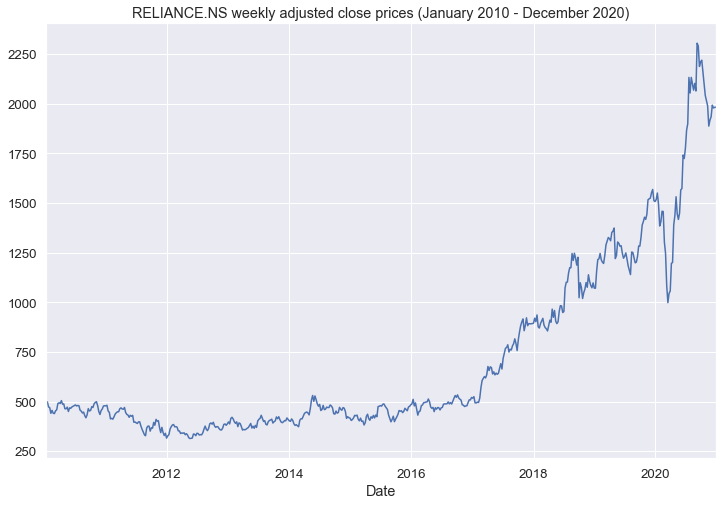

In [27]:
sns.set(font_scale=1.2)
df_training['adj_close'].plot(figsize=(12, 8), 
                     title=f"{ticker} weekly adjusted close prices ({start_training_str} - {end_training_str})")

## Model Selection

In [28]:
## Fitting the model(With more tuning of the parameters)
arima_fit = pm.auto_arima(df_training['adj_close'], error_action='ignore', suppress_warnings=True, stepwise=False, 
                           approximation=False, seasonal=False)

## Printing a summary of the model
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  574
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -2832.709
Date:                Mon, 29 May 2023   AIC                           5679.418
Time:                        09:22:50   BIC                           5709.875
Sample:                    01-10-2010   HQIC                          5691.299
                         - 01-03-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.9786      4.562      1.530      0.126      -1.962      15.920
ar.L1         -1.2658      0.062    -20.466      0.000      -1.387      -1.145
ar.L2         -0.5744      0.077     -7.467      0.000      -0.725      -0.424
ar.L3          0.1408      0.029      4.914      0.000       0.085       0.197
ma.L1          1.2864      0.060     21.548      0.000       1.169       1.403
ma.L2          0.7356      0.066     11.112      0.000       0.606       0.865
sigma2      1151.5104     31.815     36.194      0.000    1089.155    1213.866
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2783.55
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              14.91   Skew:                             0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Testing data

In [29]:
df_testing = yf.download(ticker, start=start_testing, end=end_testing, progress=False)
print(f"Downloaded {df_testing.shape[0]} rows and {df_testing.shape[1]} columns of {ticker} data")

Downloaded 594 rows and 6 columns of RELIANCE.NS data


In [30]:
## Resampling to obtain weekly stock prices with the following rules
## 'Open': first opening price of the month
## 'High': max price of the month
## 'Low': min price of the month
## 'Close' and 'Adj Close': last closing price of the month

df_testing = df_testing.resample('W').agg({'Open':'first', 'High':'max', 'Low': 'min', 'Close':'last', 'Adj Close':'last'})

In [31]:
df_testing.drop(columns=["Open", "High", "Low", "Close"], inplace=True)
df_testing.rename(columns = {'Adj Close': 'adj_close'}, inplace=True)
print(df_testing.head())

              adj_close
Date                   
2021-01-03  1975.180176
2021-01-10  1921.713623
2021-01-17  1925.440308
2021-01-24  2036.895386
2021-01-31  1830.532349


## Forecast using testing data

In [32]:
n_fcast1 = len(df_testing)

In [33]:
arima_fcast = arima_fit.predict

In [37]:
arima_fcast

<bound method ARIMA.predict of ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True)>

In [36]:
arima_fcast = [pd.DataFrame(arima_fcast[0], columns=['prediction']),pd.DataFrame(arima_fcast[1], 
                                                                                   columns=['lower_95', 'upper_95'])]

arima_fcast = pd.concat(arima_fcast, axis=1).set_index(df_testing.index)

TypeError: 'method' object is not subscriptable

In [ ]:
arima_fcast_result = arima_fcast()  # Call the method to get the result

# Access the elements of the result
arima_prediction = pd.DataFrame(arima_fcast_result[0], columns=['prediction'])
arima_confidence = pd.DataFrame(arima_fcast_result[1], columns=['lower_95', 'upper_95'])

# Concatenate the dataframes and set the index
arima_fcast_combined = pd.concat([arima_prediction, arima_confidence], axis=1).set_index(df_testing.index)


In [ ]:
arima_fcast.head()

## Plot the results

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 8))

ax = sns.lineplot(data=df_testing['adj_close'], color='black', label='Actual')

ax.plot(arima_fcast.prediction, color='red', label='ARIMA(3, 1, 2)')

ax.fill_between(arima_fcast.index, arima_fcast.lower_95, 
                arima_fcast.upper_95, alpha=0.2, 
                facecolor='red')

ax.set(title=f"{ticker} stock price - actual vs. predicted", xlabel='Date',
       ylabel='Adjusted close price (US$)')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()